In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")

print("Path to dataset files:", path)

/Users/mac/Coding/Extrovert VS Introvert/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/mac/.cache/kagglehub/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/versions/2


In [2]:
import os
import pandas as pd
import numpy as np
csv_file="personality_dataset.csv"
data_file_path=os.path.join(path,csv_file)
try:
    df=pd.read_csv(data_file_path)
    print("Data Loaded Successfuly!")
    print(df.head)
except:
    print(f"Error: {csv_filename} not found in {download_path}. Please check the actual file name and path.")

Data Loaded Successfuly!
<bound method NDFrame.head of       Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0                  4.0         No                      4.0            6.0   
1                  9.0        Yes                      0.0            0.0   
2                  9.0        Yes                      1.0            2.0   
3                  0.0         No                      6.0            7.0   
4                  3.0         No                      9.0            4.0   
...                ...        ...                      ...            ...   
2895               3.0         No                      7.0            6.0   
2896               3.0         No                      8.0            3.0   
2897               4.0        Yes                      1.0            1.0   
2898              11.0        Yes                      1.0            NaN   
2899               3.0         No                      6.0            6.0   

     Drained_after_s

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [4]:
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2837.000000,2838.000000,2834.000000,2823.000000,2835.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.479192,2.903827,2.247327,4.289693,2.926582
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.000000,3.000000,5.000000,3.000000
75%,8.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


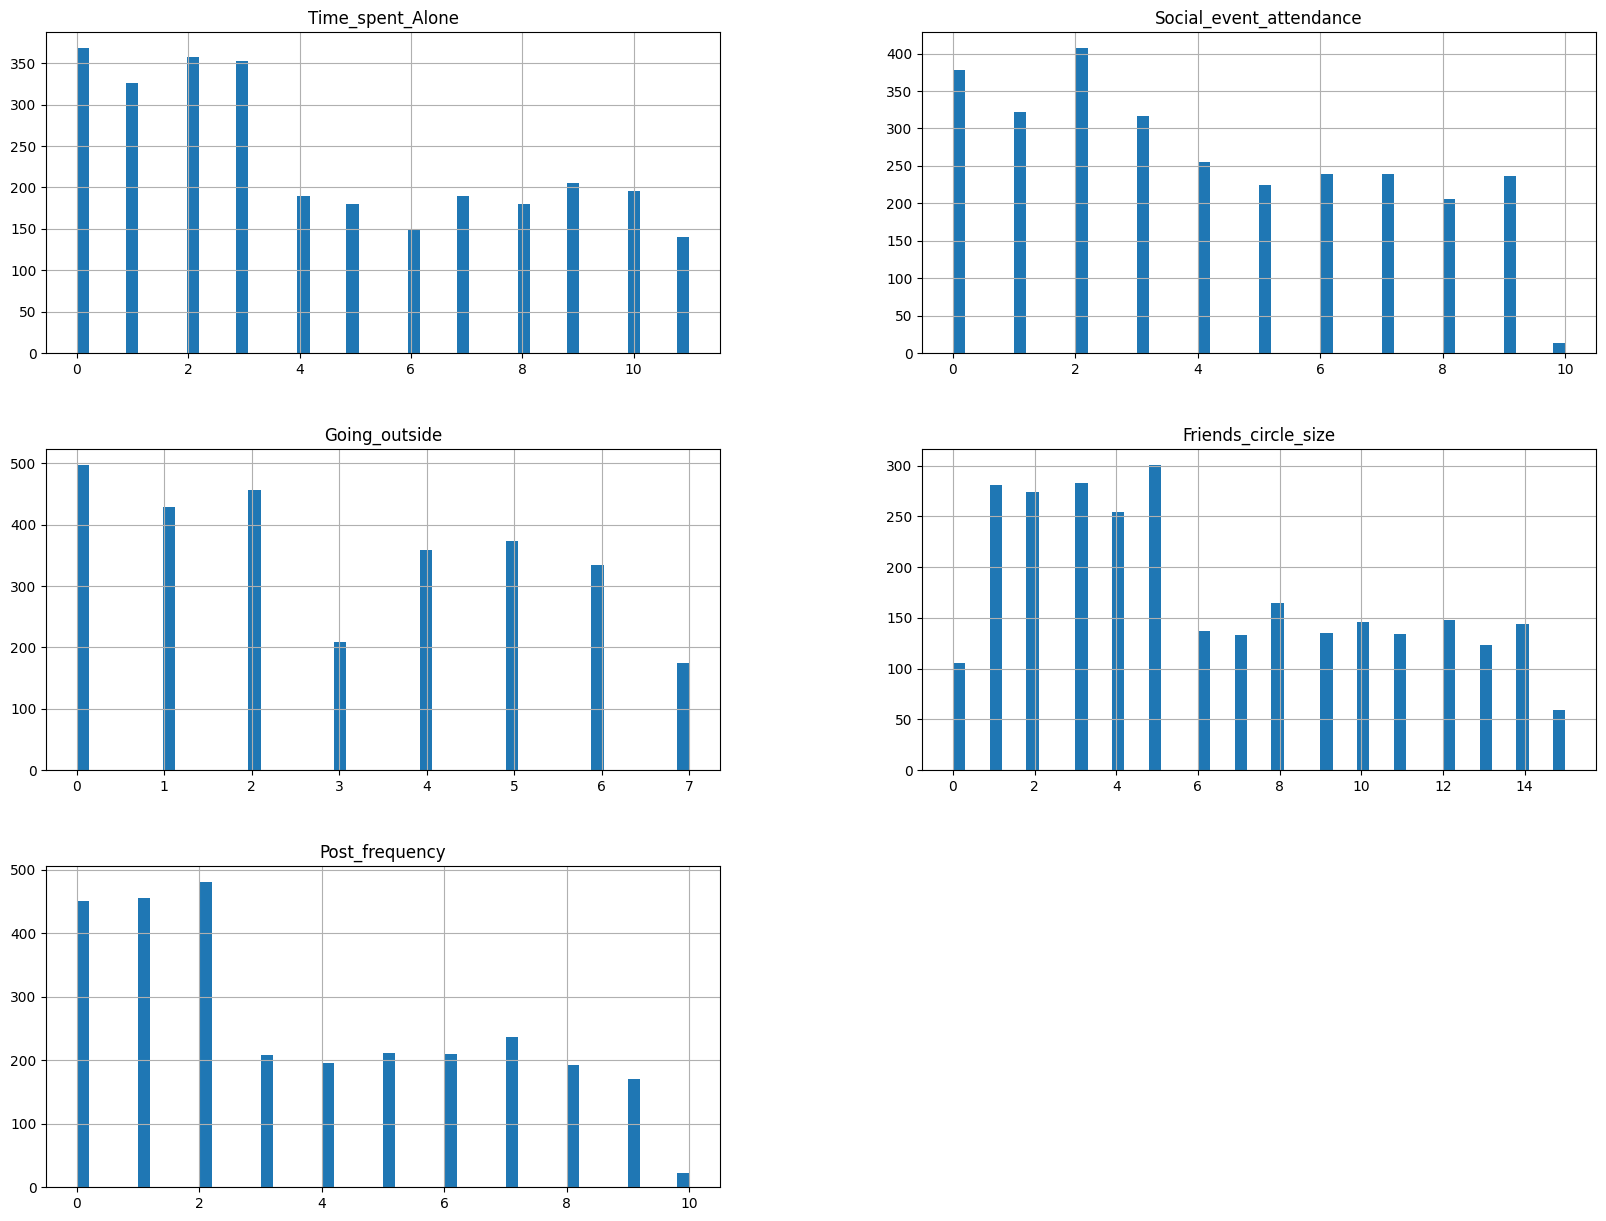

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(20,15))
plt.show()

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(df,df['Personality']):
    strat_train_set=df.loc[train_index]
    strat_test_set=df.loc[test_index]

In [7]:
strat_train_set['Personality'].value_counts()/len(strat_train_set)

Personality
Extrovert    0.514224
Introvert    0.485776
Name: count, dtype: float64

In [8]:
non_numeric=df.select_dtypes(include=['object','category']).columns.to_list()
df_numeric = df.drop(columns=non_numeric)
corr_matrix = df_numeric.corr()
corr_matrix

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
Time_spent_Alone,1.000000,-0.733011,-0.750760,-0.717185,-0.732649
Social_event_attendance,-0.733011,1.000000,0.747756,0.734795,0.744615
Going_outside,-0.750760,0.747756,1.000000,0.736390,0.770819
Friends_circle_size,-0.717185,0.734795,0.736390,1.000000,0.707888
Post_frequency,-0.732649,0.744615,0.770819,0.707888,1.000000


In [9]:
behaviour = strat_train_set.drop("Personality", axis=1)
behaviour_test=strat_test_set.drop("Personality", axis=1)
behaviour_labels = strat_train_set["Personality"].copy()
behaviour_labels_test=strat_test_set["Personality"].copy()
print(non_numeric)

['Stage_fear', 'Drained_after_socializing', 'Personality']


In [10]:
remove=[x for x in non_numeric if x!='Personality']
behaviour_num = behaviour.drop(remove, axis=1)
behaviour_cat = behaviour[["Stage_fear","Drained_after_socializing"]]
behaviour_num_test = behaviour_test.drop(remove, axis=1)
behaviour_cat_test = behaviour_test[["Stage_fear","Drained_after_socializing"]]


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler())
])


cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ('encoder', OrdinalEncoder())
])


full_pipeline = ColumnTransformer([
    ('num', num_pipeline, behaviour_num.columns),
    ('cat', cat_pipeline, behaviour_cat.columns)
])

behaviour_prepared = full_pipeline.fit_transform(behaviour)
behaviour_prepared_test = full_pipeline.transform(behaviour_test)

In [12]:
import pandas as pd

num_features = behaviour_num.columns.tolist()
cat_features = behaviour_cat.columns.tolist()
all_features = num_features + cat_features

behaviour_prepared_df = pd.DataFrame(behaviour_prepared, columns=all_features)

print(behaviour_prepared_df.shape)                   
print(behaviour_prepared_df.isnull().sum())          
print(behaviour_prepared_df.Social_event_attendance.count())  



(2320, 7)
Time_spent_Alone             0
Social_event_attendance      0
Going_outside                0
Friends_circle_size          0
Post_frequency               0
Stage_fear                   0
Drained_after_socializing    0
dtype: int64
2320


In [13]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression()
log_reg.fit(behaviour_prepared,behaviour_labels)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [14]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(log_reg,behaviour_prepared,behaviour_labels,scoring='accuracy',cv=10)
print("Accuracy scores from each fold:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Accuracy scores from each fold: [0.93534483 0.91810345 0.93534483 0.92241379 0.93534483 0.93534483
 0.9137931  0.94827586 0.93103448 0.94827586]
Mean accuracy: 0.9323275862068966
Standard deviation: 0.01091292146652771


In [15]:
from sklearn.ensemble import RandomForestClassifier
forest_clas = RandomForestClassifier(max_depth=5,max_features='sqrt',random_state=42,class_weight='balanced')
forest_clas.fit(behaviour_prepared, behaviour_labels)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
forest_clas_scores=cross_val_score(forest_clas,behaviour_prepared,behaviour_labels,scoring='accuracy',cv=10)
print("Accuracy scores from each fold:", forest_clas_scores)
print("Mean accuracy:", forest_clas_scores.mean())
print("Standard deviation:", forest_clas_scores.std())

Accuracy scores from each fold: [0.95689655 0.92672414 0.94396552 0.92672414 0.93965517 0.93965517
 0.9137931  0.9612069  0.93103448 0.94827586]
Mean accuracy: 0.9387931034482759
Standard deviation: 0.013873687016750916


In [17]:
from sklearn.tree import DecisionTreeClassifier
des_tree_clas=DecisionTreeClassifier(max_depth=5,max_features='sqrt',random_state=42)
des_tree_clas.fit(behaviour_prepared,behaviour_labels)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [18]:
d_scores=cross_val_score(des_tree_clas,behaviour_prepared,behaviour_labels,scoring='accuracy',cv=10)
print("Accuracy scores from each fold:", d_scores)
print("Mean accuracy:", d_scores.mean())
print("Standard deviation:", d_scores.std())

Accuracy scores from each fold: [0.95689655 0.92672414 0.94396552 0.92241379 0.93965517 0.93965517
 0.9137931  0.9612069  0.93103448 0.94827586]
Mean accuracy: 0.9383620689655172
Standard deviation: 0.01430229312330779


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
gr_clas=GradientBoostingClassifier()
gr_clas.fit(behaviour_prepared,behaviour_labels)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [20]:
gr_scores=cross_val_score(gr_clas,behaviour_prepared,behaviour_labels,scoring='accuracy',cv=10)
print("Accuracy scores from each fold:", gr_scores)
print("Mean accuracy:", gr_scores.mean())
print("Standard deviation:", gr_scores.std())

Accuracy scores from each fold: [0.95689655 0.92672414 0.94396552 0.92672414 0.93965517 0.93965517
 0.90948276 0.9612069  0.93103448 0.94827586]
Mean accuracy: 0.9383620689655172
Standard deviation: 0.014686831928793814


In [21]:
from sklearn.metrics import accuracy_score, classification_report
behaviour_predictions_train=forest_clas.predict(behaviour_prepared)
print("Accuracy:",accuracy_score(behaviour_predictions_train,behaviour_labels))
print(classification_report(behaviour_labels, behaviour_predictions_train))

Accuracy: 0.9387931034482758
              precision    recall  f1-score   support

   Extrovert       0.95      0.93      0.94      1193
   Introvert       0.93      0.94      0.94      1127

    accuracy                           0.94      2320
   macro avg       0.94      0.94      0.94      2320
weighted avg       0.94      0.94      0.94      2320



In [22]:
behaviour_predictions_test=forest_clas.predict(behaviour_prepared_test)
print("Accuracy:",accuracy_score(behaviour_predictions_test,behaviour_labels_test))
print(classification_report(behaviour_labels_test, behaviour_predictions_test))

Accuracy: 0.9172413793103448
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



In [23]:
def predict_personality(
    Time_spent_Alone, Social_event_attendance, Going_outside,
    Friends_circle_size, Post_frequency, Stage_fear, Drained_after_socializing,model
):
    import pandas as pd

    input_data = pd.DataFrame([{
        "Time_spent_Alone": Time_spent_Alone,
        "Social_event_attendance": Social_event_attendance,
        "Going_outside": Going_outside,
        "Friends_circle_size": Friends_circle_size,
        "Post_frequency": Post_frequency,
        "Stage_fear": Stage_fear,
        "Drained_after_socializing": Drained_after_socializing
    }])
    input_data_test = full_pipeline.transform(input_data)
    prediction = model.predict(input_data_test)
    return prediction[0]


In [24]:
'''Time_spent_Alone=int(input("Enter Time Spent Alone"))
Social_event_attendance=int(input("Enter the number of hours you attend any social event"))
Going_outside=int(input("How many hours do you go outside"))
Friends_circle_size=int(input("Whats your Friend Circle size"))
Post_frequency=int(input("Social media post frequency"))
Stage_fear=input("Presence of stage fright (Yes/No)")
Drained_after_socializing=input("Feeling drained after socializing (Yes/No).")
print(predict_personality(
    Time_spent_Alone, Social_event_attendance, Going_outside,
    Friends_circle_size, Post_frequency, Stage_fear, Drained_after_socializing,forest_clas
))'''

'Time_spent_Alone=int(input("Enter Time Spent Alone"))\nSocial_event_attendance=int(input("Enter the number of hours you attend any social event"))\nGoing_outside=int(input("How many hours do you go outside"))\nFriends_circle_size=int(input("Whats your Friend Circle size"))\nPost_frequency=int(input("Social media post frequency"))\nStage_fear=input("Presence of stage fright (Yes/No)")\nDrained_after_socializing=input("Feeling drained after socializing (Yes/No).")\nprint(predict_personality(\n    Time_spent_Alone, Social_event_attendance, Going_outside,\n    Friends_circle_size, Post_frequency, Stage_fear, Drained_after_socializing,forest_clas\n))'

In [25]:
print(strat_train_set[strat_train_set['Post_frequency'] == 0]['Personality'].value_counts())


Personality
Introvert    331
Extrovert     25
Name: count, dtype: int64


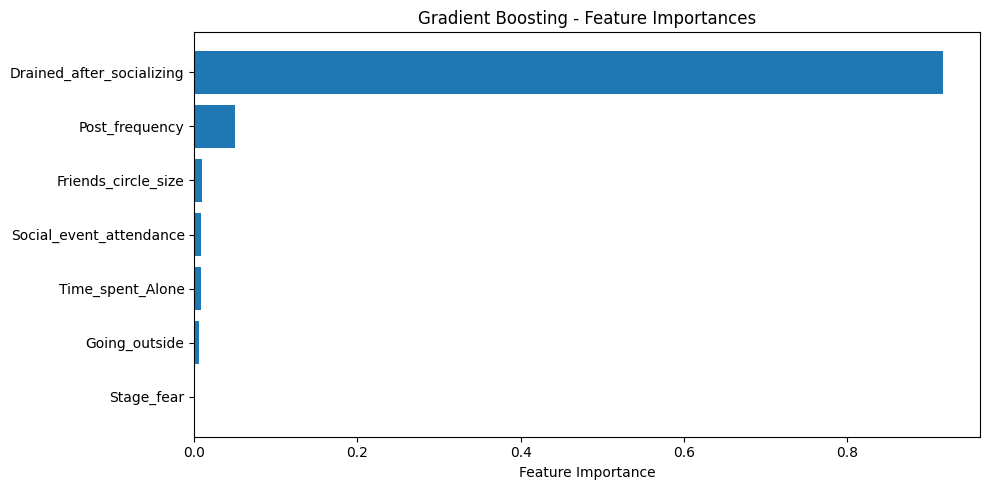

In [26]:
import matplotlib.pyplot as plt

feature_names = behaviour_num.columns.tolist() + behaviour_cat.columns.tolist()

importances = gr_clas.feature_importances_
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting - Feature Importances")
plt.tight_layout()
plt.show()


<Axes: xlabel='Post_frequency', ylabel='count'>

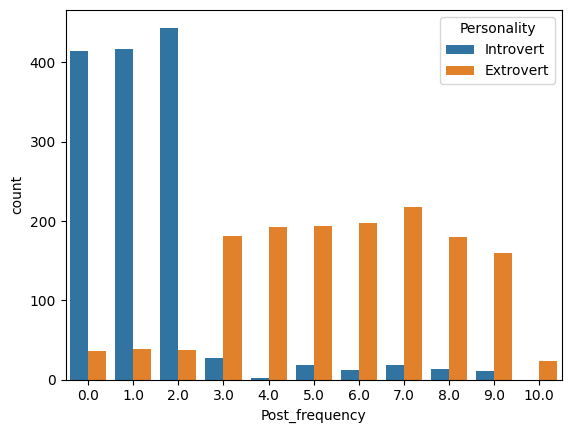

In [27]:
import seaborn as sns
sns.countplot(x='Post_frequency', hue='Personality', data=df)

In [28]:
behaviour_no_post= behaviour.drop('Post_frequency', axis=1)
behaviour_no_post_test=behaviour_test.drop('Post_frequency', axis=1)
behaviour_no_post_num = behaviour_num.drop('Post_frequency', axis=1)
behaviour_no_post_cat = behaviour_no_post[["Stage_fear","Drained_after_socializing"]]

In [29]:
full_pipeline_no_post = ColumnTransformer([
    ('num', num_pipeline, behaviour_no_post_num.columns),
    ('cat', cat_pipeline, behaviour_no_post_cat.columns)
])

behaviour_no_post_prepared = full_pipeline_no_post.fit_transform(behaviour_no_post)
behaviour_no_post_prepared_test = full_pipeline_no_post.transform(behaviour_no_post_test)

In [30]:
forest_clas_new = RandomForestClassifier(max_depth=5,max_features='sqrt',random_state=42,class_weight='balanced')
forest_clas_new.fit(behaviour_no_post_prepared, behaviour_labels)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
forest_clas_new_scores=cross_val_score(forest_clas_new,behaviour_no_post_prepared,behaviour_labels,scoring='accuracy',cv=10)
print("Accuracy scores from each fold:", forest_clas_new_scores)
print("Mean accuracy:", forest_clas_new_scores.mean())
print("Standard deviation:", forest_clas_new_scores.std())

Accuracy scores from each fold: [0.95689655 0.92672414 0.94396552 0.92672414 0.93965517 0.93965517
 0.9137931  0.9612069  0.93103448 0.94827586]
Mean accuracy: 0.9387931034482759
Standard deviation: 0.013873687016750916


In [32]:
from sklearn.metrics import accuracy_score, classification_report
behaviour_predictions_no_post_train=forest_clas_new.predict(behaviour_no_post_prepared)
print("Accuracy:",accuracy_score(behaviour_predictions_no_post_train,behaviour_labels))
print(classification_report(behaviour_labels, behaviour_predictions_no_post_train))

Accuracy: 0.9387931034482758
              precision    recall  f1-score   support

   Extrovert       0.95      0.93      0.94      1193
   Introvert       0.93      0.94      0.94      1127

    accuracy                           0.94      2320
   macro avg       0.94      0.94      0.94      2320
weighted avg       0.94      0.94      0.94      2320



In [33]:
behaviour_predictions_no_post_test=forest_clas_new.predict(behaviour_no_post_prepared_test)
print("Accuracy:",accuracy_score(behaviour_predictions_no_post_test,behaviour_labels_test))
print(classification_report(behaviour_labels_test, behaviour_predictions_no_post_test))

Accuracy: 0.9172413793103448
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



In [34]:
def predict_personality_new(
    Time_spent_Alone, Social_event_attendance, Going_outside,
    Friends_circle_size, Stage_fear, Drained_after_socializing,model
):
    import pandas as pd

    input_data = pd.DataFrame([{
        "Time_spent_Alone": Time_spent_Alone,
        "Social_event_attendance": Social_event_attendance,
        "Going_outside": Going_outside,
        "Friends_circle_size": Friends_circle_size,
        "Stage_fear": Stage_fear,
        "Drained_after_socializing": Drained_after_socializing
    }])
    input_data_test = full_pipeline_no_post.transform(input_data)
    prediction = model.predict(input_data_test)
    return prediction[0]


In [35]:
Time_spent_Alone=int(input("Enter Time Spent Alone"))
Social_event_attendance=int(input("Enter the number of hours you attend any social event"))
Going_outside=int(input("How many hours do you go outside"))
Friends_circle_size=int(input("Whats your Friend Circle size"))
Stage_fear=input("Presence of stage fright (Yes/No)")
Drained_after_socializing=input("Feeling drained after socializing (Yes/No).")
print(predict_personality_new(
    Time_spent_Alone, Social_event_attendance, Going_outside,
    Friends_circle_size, Stage_fear, Drained_after_socializing,forest_clas_new
))

Extrovert
